# BRDF Representation

## Mitsuba "Deep Dive"

In [175]:
import drjit as dr
import mitsuba as mi

mi.set_variant("llvm_ad_rgb")

In [176]:
bsdf = mi.load_dict({
    'type': 'roughconductor',
    'alpha': 0.2,
    'distribution': 'ggx'
})
bsdf

RoughConductor[
  distribution = ggx,
  sample_visible = 1,
  alpha_u = UniformSpectrum[value=[0.2]],
  alpha_v = UniformSpectrum[value=[0.2]],
  eta = UniformSpectrum[value=[0]],
  k = UniformSpectrum[value=[1]]
]

In [177]:
def sph_to_eucl(theta, phi):
    st, ct = dr.sincos(theta)
    sp, cp = dr.sincos(phi)
    return mi.Vector3f(cp * st, sp * st, ct)

In [178]:
# Create a dummy surface interaction to use for the evaluation of the BSDF
si = dr.zeros(mi.SurfaceInteraction3f)

# Specify an incident direction with X degrees
si.wi = sph_to_eucl(dr.deg2rad(45.0), dr.deg2rad(0.0))

# Create grid in spherical coordinates and map it into a sphere
res = 500
zeniths_o, azimuths_o = dr.meshgrid(
    dr.linspace(mi.Float, 0,     dr.pi,     res),
    dr.linspace(mi.Float, 0, 2 * dr.pi, 2 * res)
)
wo = sph_to_eucl(zeniths_o, azimuths_o)

# Evaluate the BSDF
brdf_values = bsdf.eval(mi.BSDFContext(), si, wo)

In [179]:
import numpy as np
brdf_np = np.array(brdf_values)

In [180]:
brdf_data = brdf_np[:,0]

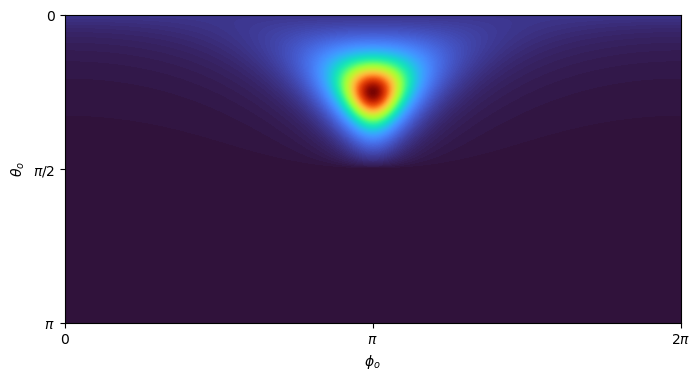

In [181]:
import matplotlib.pyplot as plt

# Extract red channel of BRDF values and reshape into 2D grid
brdf_data = brdf_data.reshape(2 * res, res).T

# Plot values for spherical coordinates
fig, ax = plt.subplots(figsize=(8, 4))

im = ax.imshow(brdf_data, extent=[0, 2 * np.pi, np.pi, 0], cmap='turbo')

ax.set_xlabel(r'$\phi_o$', size=10)
ax.set_xticks([0, dr.pi, dr.two_pi])
ax.set_xticklabels(['0', '$\\pi$', '$2\\pi$'])
ax.set_ylabel(r'$\theta_o$', size=10)
ax.set_yticks([0, dr.pi / 2, dr.pi])
ax.set_yticklabels(['0', '$\\pi/2$', '$\\pi$']);


## Converting to Polar representation of the BRDF

In [182]:
# Combine zeniths, azimuths and BRDF values into a single array
zeniths = np.array(zeniths_o)
azimuths = np.array(azimuths_o)
brdf_data = np.array(brdf_data).T.flatten()
data = np.stack([zeniths, azimuths, brdf_data], axis=1)

# Remove rows where the zenith (first element) is greater than 90 degrees
data = data[data[:, 0] <= np.pi / 2]

# Extract the new values
zeniths_t = data[:, 0]
azimuths_t = data[:, 1]
brdf_data_t = data[:, 2]

### Simple Polar Plot

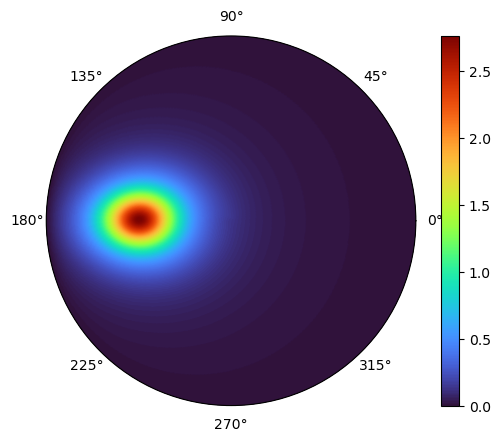

In [184]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.scatter(azimuths_t, zeniths_t, c=brdf_data_t, cmap='turbo', s=1)
ax.grid(False)
ax.set_yticklabels([])
cbar = fig.colorbar(im, ax=ax, orientation='vertical')
ax.set_ylim(0, np.pi / 2)
plt.show()

### Tricontourf Polar Plot

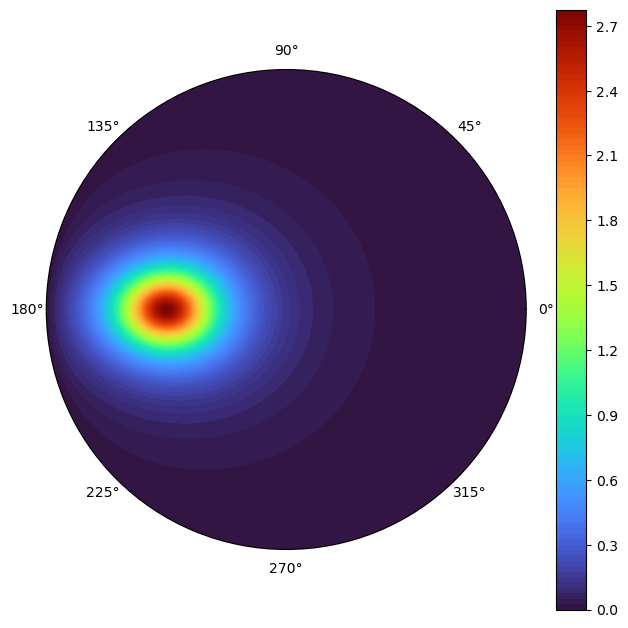

In [186]:
import matplotlib.tri as tri

levels = 128

# Transform zenith into degree
zeniths_deg = np.rad2deg(zeniths_t)

# Create triangulation
x = zeniths_deg * np.cos(azimuths_t)
y = zeniths_deg * np.sin(azimuths_t)
triangles = tri.Triangulation(x, y)

# Make plot
fig = plt.figure(figsize=(6,6))
rect = [0, 0, 1, 1]

# Main plot in Cartesian coordinates
ax_cartesian = fig.add_axes(rect, frameon=False, aspect='equal')
ax_cartesian.axis('off')
ctr = ax_cartesian.tricontourf(triangles, brdf_data_t, levels=levels, cmap='turbo')

# Show the contours
#ax_cartesian.tricontour(triangles, brdf_data_t, levels=levels, colors='k', linewidths=0.5)

# Match limits with the full zenith range
ax_cartesian.set_xlim([-90, 90])
ax_cartesian.set_ylim([-90, 90])

# Polar axes
ax_polar = fig.add_axes(rect, polar=True, facecolor="none")
ax_polar.set_rlim([0, 90])          # Cover the full zenith value range
ax_polar.grid(False)                # Hide the polar grid
ax_polar.set_yticklabels([])        # No radial tick labels

# Add the color bar (important: both axes must be adjusted)
fig.colorbar(ctr, ax=[ax_cartesian, ax_polar])

plt.show()
plt.close()

# Ocean BRDF

First we write a function to scale the wind speed to the maximum of 38 m/s such that whitecap coverage will not exceed 1.0.

In [ ]:
def convert_wind_speed(wind_speed):
    return max(0.0, min(1.0, wind_speed / 38.0))